# Data Modeling - Churn Prediction

## Vue d'ensemble du notebook

Ce notebook effectue l'entraînement et l'évaluation de trois modèles de classification supervisée pour prédire le churn des clients bancaires:

1. **Logistic Regression** - Un modèle linéaire simple et interprétable
2. **Random Forest** - Un ensemble d'arbres de décision robuste au surapprentissage
3. **XGBoost** - Un modèle de gradient boosting hautement performant

Chaque modèle est évalué à l'aide de métriques de classification standard (accuracy, precision, recall, F1-score, ROC-AUC) et de la validation croisée pour assurer la robustesse des résultats.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV # for hyperparameter tuning
import optuna as optuna # for hyperparameter tuning
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from imblearn.over_sampling import SMOTE
import shap # for model interpretability
import sys
sys.path.append('../src')
from EvaluationFunction import evaluate_model
from ValidationCross import cross_val_results
import shap

## 1. Chargement et exploration des données

Nous chargeons les données prétraitées depuis le fichier CSV. Ces données ont déjà été nettoyées et préparées dans les étapes précédentes du pipeline.


In [4]:
#load the preprocessed data
df = pd.read_csv("../data/preprocessed_data.csv") 
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Ratio_Balance_Age,Ratio_Salary_Age,Engagement_Score,Ratio_Products_Age,Relative_Salary,Ratio_CreditScore_Age,Zero_Balance_HasCrCard,Low_Balance_Active,Active_HasCrCard,Log_Salary
0,683.0,Germany,Male,49.0,7.0,123837.86,2.0,1.0,1.0,138700.75,...,2527.303265,2830.627551,4.0,0.040816,1.161679,13.938776,False,False,1.0,11.840081
1,608.0,France,Female,30.0,10.0,0.00,2.0,1.0,1.0,146723.72,...,0.000000,4890.790667,4.0,0.066667,1.248591,20.266667,True,True,1.0,11.896313
2,539.0,France,Female,32.0,8.0,0.00,1.0,1.0,1.0,94873.60,...,0.000000,2964.800000,3.0,0.031250,0.807356,16.843750,True,True,1.0,11.460311
3,530.0,Spain,Female,39.0,8.0,0.00,2.0,0.0,0.0,177896.93,...,0.000000,4561.459744,2.0,0.051282,1.511382,13.589744,False,False,0.0,12.088965
4,613.0,France,Female,45.0,10.0,0.00,2.0,1.0,1.0,116748.14,...,0.000000,2594.403111,4.0,0.044444,0.993504,13.622222,True,True,1.0,11.667783


In [5]:
# Define features and target variable
X = df.drop("Exited", axis=1)
y = df["Exited"]

In [6]:
# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

---
Preprocessor
---

In [7]:
# Identify numerical and categorical columns
num_var = X.select_dtypes(include=["float64", "int64"]).columns
cat_var = X.select_dtypes(include=["object","category"]).columns

In [8]:
# 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_var),           
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_var)
    ]
)

##  Entraînement des modèles

Nous entraînons trois modèles de classification:

### Logistic Regression
- **Type**: Modèle linéaire
- **Avantages**: Simple, rapide, hautement interprétable
- **Paramètres clés**: 
  - `max_iter=1000` : nombre d'itérations
  - `class_weight='balanced'` : gère le déséquilibre des classes

### Random Forest
- **Type**: Ensemble d'arbres de décision
- **Avantages**: Robuste au surapprentissage, gère les non-linéarités
- **Paramètres clés**: 
  - `n_estimators=300` : nombre d'arbres
  - `max_depth=10` : profondeur maximale de chaque arbre
  - `class_weight='balanced'` : gère le déséquilibre

### XGBoost
- **Type**: Gradient Boosting
- **Avantages**: Très performant, gère bien les données complexes
- **Paramètres clés**: 
  - `n_estimators=300` : nombre de boosting rounds
  - `learning_rate=0.05` : vitesse d'apprentissage
  - `scale_pos_weight=3` : pénalité pour la classe minoritaire (churn)


=== Logistic Regression ===
Accuracy: 0.8116666666666666
Precision: 0.5174234424498416
Recall: 0.8193979933110368
F1-score: 0.6343042071197411
AUC: 0.8911971350518938

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.81      0.87      2402
           1       0.52      0.82      0.63       598

    accuracy                           0.81      3000
   macro avg       0.73      0.81      0.75      3000
weighted avg       0.86      0.81      0.83      3000



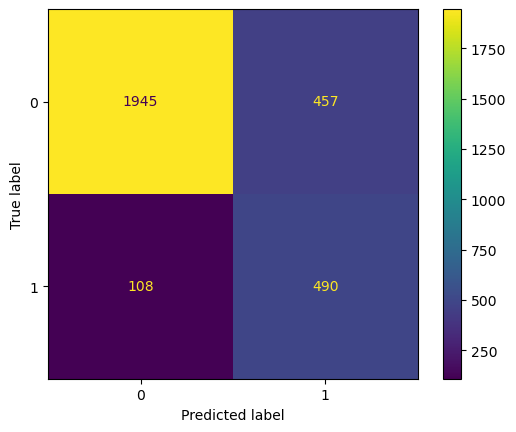


=== Random Forest ===
Accuracy: 0.8833333333333333
Precision: 0.6845238095238095
Recall: 0.7692307692307693
F1-score: 0.7244094488188977
AUC: 0.9297825947719155

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      2402
           1       0.68      0.77      0.72       598

    accuracy                           0.88      3000
   macro avg       0.81      0.84      0.83      3000
weighted avg       0.89      0.88      0.89      3000



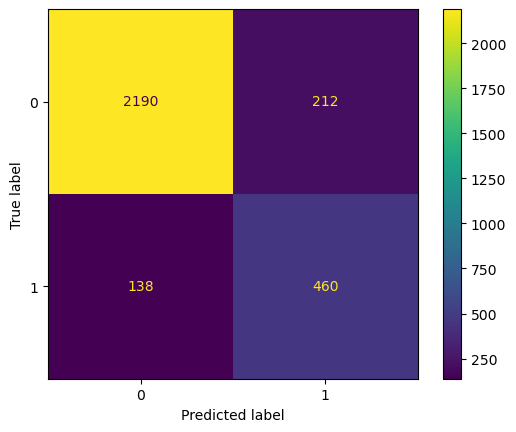

c:\Users\CYTech Student\anaconda3\envs\mon_env\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:38:53] WARNING: C:\miniconda3\conda-bld\xgboost-split_1764761400759\work\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost ===
Accuracy: 0.88
Precision: 0.6685552407932012
Recall: 0.7892976588628763
F1-score: 0.7239263803680982
AUC: 0.9305825134572917

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      2402
           1       0.67      0.79      0.72       598

    accuracy                           0.88      3000
   macro avg       0.81      0.85      0.82      3000
weighted avg       0.89      0.88      0.88      3000



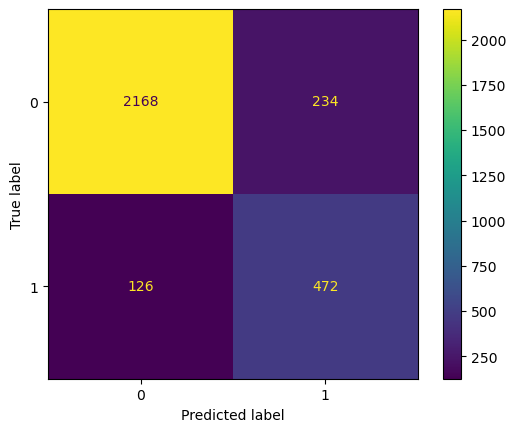

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] Total Bins 2499
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_s

c:\Users\CYTech Student\anaconda3\envs\mon_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\CYTech Student\anaconda3\envs\mon_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


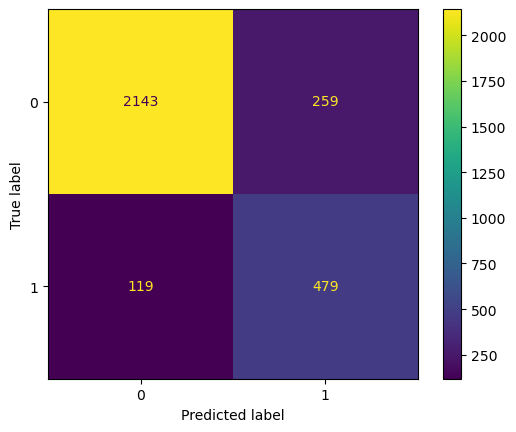

In [17]:
# ===========================
# Logistic Regression Model
# ===========================
log_reg = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]

print("=== Logistic Regression ===")
evaluate_model(y_test, y_pred_lr, y_prob_lr)


# ===========================
# Random Forest Model
# ===========================
rf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        class_weight='balanced',
        random_state=42
    ))
])

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("\n=== Random Forest ===")
evaluate_model(y_test, y_pred_rf, y_prob_rf)


# ===========================
# XGBoost Model
# ===========================
xgb = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=3,  # gérer le déséquilibre
        eval_metric='logloss',
        random_state=42,
        use_label_encoder=False  # Important pour éviter les warnings
    ))
])

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

print("\n=== XGBoost ===")
evaluate_model(y_test, y_pred_xgb, y_prob_xgb)

# ===========================
# LGBMClassifier Model
# ===========================
lgbm = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,              # IMPORTANT
    min_data_in_leaf=10,
    min_gain_to_split=0.0,
    scale_pos_weight=4.0,      # ratio réel
    random_state=42,
    force_col_wise=True
))
])

lgbm.fit(X_train, y_train)

y_pred_lgbm = lgbm.predict(X_test)
y_prob_lgbm = lgbm.predict_proba(X_test)[:, 1]

print("\n=== LightGBM ===")
evaluate_model(y_test, y_pred_lgbm, y_prob_lgbm)


---
Validation croisée
---

In [18]:
print("=== Cross Validation: Logistic Regression ===")
cross_val_results(log_reg, X_train, y_train)

print("=== Cross Validation: Random Forest ===")
cross_val_results(rf, X_train, y_train)

print("=== Cross Validation: XGBoost ===")
cross_val_results(xgb, X_train, y_train)

print("=== Cross Validation: LightBoost ===")
cross_val_results(lgbm, X_train, y_train)

=== Cross Validation: Logistic Regression ===
----- Cross Validation Scores -----
accuracy: 0.8129 ± 0.0089
precision: 0.5200 ± 0.0142
recall: 0.8052 ± 0.0131
f1: 0.6319 ± 0.0142
roc_auc: 0.8851 ± 0.0090


=== Cross Validation: Random Forest ===
----- Cross Validation Scores -----
accuracy: 0.8893 ± 0.0050
precision: 0.7020 ± 0.0124
recall: 0.7730 ± 0.0131
f1: 0.7358 ± 0.0118
roc_auc: 0.9318 ± 0.0056


=== Cross Validation: XGBoost ===
----- Cross Validation Scores -----
accuracy: 0.8852 ± 0.0032
precision: 0.6811 ± 0.0086
recall: 0.7972 ± 0.0056
f1: 0.7346 ± 0.0065
roc_auc: 0.9326 ± 0.0047


=== Cross Validation: LightBoost ===
----- Cross Validation Scores -----
accuracy: 0.8776 ± 0.0018
precision: 0.6588 ± 0.0045
recall: 0.8006 ± 0.0141
f1: 0.7227 ± 0.0058
roc_auc: 0.9295 ± 0.0054


